## Canine GWAS Variant QC


In [1]:
import hail as hl
import pandas as pd
import numpy as np
import plotnine as pn
import functools 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import os.path as osp
# from bokeh.io import show, output_notebook
# from bokeh.layouts import gridplot
# output_notebook()
%run ../../nb.py
%run files.py
%run common.py
gab.register_timeop_magic(get_ipython(), 'hail')
hl.init()

Running on Apache Spark version 2.4.4
SparkUI available at http://d42c6af5a4e5:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.30-2ae07d872f43
LOGGING: writing to /home/eczech/repos/gwas-analysis/notebooks/organism/canine/hail-20200211-0424-0.2.30-2ae07d872f43.log


### Reference Data QC

The initial steps in the pipeline will involved loading the NHGRI Dog Genome data and running some basic QC steps, including:
    
- Run call rate filtering
- Group the samples by the 3 most common breeds
- Run MAF and HWE filtering on all variants for each breed separately, and identify variants that pass all filters in all breeds
- Filter the original reference data to the passing variant set
- Run LD pruning
- Remove C/G and A/T SNPs

In [2]:
hl.ReferenceGenome(**load_reference_genome(REF_GENOME_FILE))

ReferenceGenome(name=canine, contigs=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '41'], lengths={'1': 122670980, '2': 85416217, '3': 91858198, '4': 88267880, '5': 88908300, '6': 77552613, '7': 80858461, '8': 74057381, '9': 61043804, '10': 69316974, '11': 74388336, '12': 72480470, '13': 63232306, '14': 60959782, '15': 64187680, '16': 59511764, '17': 64281982, '18': 55763074, '19': 53735656, '20': 58114749, '21': 50855586, '22': 61382644, '23': 52291577, '24': 47651928, '25': 51628093, '26': 38939728, '27': 45753342, '28': 41164216, '29': 41841565, '30': 40196606, '31': 39786599, '32': 38745890, '33': 31361794, '34': 42089769, '35': 26506199, '36': 30798114, '37': 30897806, '38': 23903967, '39': 123833839, '41': 6608343}, x_contigs=['39'], y_contigs=[], mt_contigs=['41'], par=[])

In [98]:
mt = hl.import_plink(
    *plink_files(ORGANISM_CANINE_REF_DIR, PLINK_FILE_REF),
    skip_invalid_loci=False, 
    reference_genome='canine'
)
mt.count()

2020-02-11 06:14:01 Hail: INFO: Found 1355 samples in fam file.
2020-02-11 06:14:01 Hail: INFO: Found 150131 variants in bim file.
2020-02-11 06:14:01 Hail: INFO: Coerced sorted dataset


(150131, 1355)

#### Call Rate QC

In [99]:
threshold_call_rate = .96

2020-02-11 06:16:53 Hail: INFO: Coerced sorted dataset
2020-02-11 06:17:00 Hail: INFO: Coerced sorted dataset
2020-02-11 06:17:01 Hail: INFO: Coerced sorted dataset
2020-02-11 06:17:01 Hail: INFO: Coerced sorted dataset
/opt/conda/envs/hail/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning:

divide by zero encountered in log10



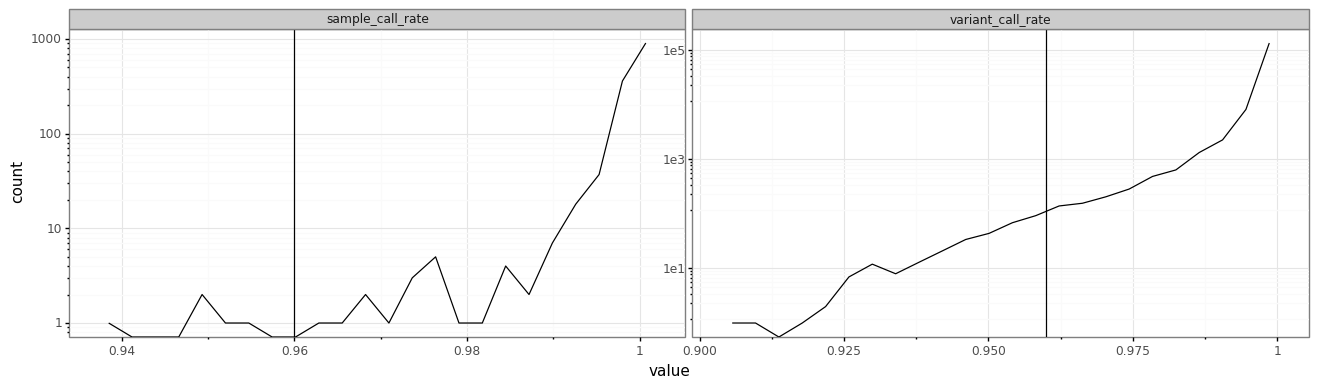

<ggplot: (8764419134853)>

In [104]:
# Find a way to do histogram visualizations for multiple traces (and thresholds) that doesn't involve 
# collecting vectors of size equal to num variants
(
    pn.ggplot(
        pd.concat([
            pd.Series(hl.sample_qc(mt).sample_qc.call_rate.collect())
            .rename('value').to_frame().assign(metric='sample_call_rate'),
            pd.Series(hl.variant_qc(mt).variant_qc.call_rate.collect())
            .rename('value').to_frame().assign(metric='variant_call_rate')
        ]),
        pn.aes(x='value') 
    ) + 
    pn.geom_freqpoly(bins=24) + 
    pn.geom_vline(xintercept=threshold_call_rate) + 
    pn.scale_y_log10() + 
    pn.facet_wrap(' ~ metric', scales='free') + 
    pn.theme_bw() + 
    pn.theme(figure_size=(16, 4))
)

In [105]:
def call_rate_qc(mt):
    mt = hl.variant_qc(mt)
    mt = mt.filter_rows(mt.variant_qc.call_rate >= threshold_call_rate)
    mt = hl.sample_qc(mt)
    mt = mt.filter_cols(mt.sample_qc.call_rate >= threshold_call_rate)
    return mt
mt_qc = call_rate_qc(mt)
mt_qc.count()

2020-02-11 06:17:39 Hail: INFO: Coerced sorted dataset
2020-02-11 06:17:46 Hail: INFO: Coerced sorted dataset
2020-02-11 06:17:54 Hail: INFO: Coerced sorted dataset
2020-02-11 06:17:55 Hail: INFO: Coerced sorted dataset


(149845, 1350)

In [106]:
mt_qc.write('/tmp/mt_ref_qc_1.mt', overwrite=True)

2020-02-11 06:18:02 Hail: INFO: Coerced sorted dataset
2020-02-11 06:18:26 Hail: INFO: Coerced sorted dataset
2020-02-11 06:18:33 Hail: INFO: Coerced sorted dataset
2020-02-11 06:19:13 Hail: INFO: wrote matrix table with 149845 rows and 1350 columns in 2 partitions to /tmp/mt_ref_qc_1.mt


#### MAF and HWE QC

In [134]:
# These are the UKBB thresholds for 1KG data (S 2.2)
threshold_hwep, threshold_maf = 10e-6, .05
threshold_hwep, threshold_maf

(1e-05, 0.05)

In [135]:
mt = hl.read_matrix_table('/tmp/mt_ref_qc_1.mt')

In [136]:
df = get_fam(ORGANISM_CANINE_REF_DIR, PLINK_FILE_REF).assign(breed=get_breed)
df.head()

,fid,iid,iid_paternal,iid_maternal,sex,pheno,breed
0,SALU_CentAsia,SALU_13122,0,0,0,-9,SALU
1,AZWK_Mali,AZWK_15369,0,0,0,-9,AZWK
2,SALU_CentAsia,SALU_22847,0,0,0,-9,SALU
3,SALU_CentAsia,SALU_22848,0,0,0,-9,SALU
4,AZWK_Mali,AZWK_23339,0,0,0,-9,AZWK


In [137]:
ht = hl.Table.from_pandas(df[['fid', 'iid', 'breed']].rename(columns={'fid': 'fam_id', 'iid': 's'})).key_by('s')
mt = mt.annotate_cols(breed=ht[mt.s].breed)
cht = mt.cols()
cht.select(cht.fam_id, cht.breed).show(3)

2020-02-11 06:43:06 Hail: INFO: Coerced sorted dataset


s,fam_id,breed
str,str,str
"""ACKR_09007""","""ACKR""","""ACKR"""
"""ACKR_09030""","""ACKR""","""ACKR"""
"""ACKR_09032""","""ACKR""","""ACKR"""


In [138]:
top_breeds = df['breed'].value_counts().sort_values().tail(3).index.tolist()
mts = {br: mt.filter_cols(mt.breed == br) for br in top_breeds}

In [139]:
mts[top_breeds[0]].cols().show(3)

s,fam_id,pat_id,mat_id,is_female,is_case,sample_qc.call_rate,sample_qc.n_called,sample_qc.n_not_called,sample_qc.n_filtered,sample_qc.n_hom_ref,sample_qc.n_het,sample_qc.n_hom_var,sample_qc.n_non_ref,sample_qc.n_singleton,sample_qc.n_snp,sample_qc.n_insertion,sample_qc.n_deletion,sample_qc.n_transition,sample_qc.n_transversion,sample_qc.n_star,sample_qc.r_ti_tv,sample_qc.r_het_hom_var,sample_qc.r_insertion_deletion,breed
str,str,str,str,bool,bool,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,str
"""MALT_27446""","""MALT""",NA,NA,NA,NA,9.97e-01,149351,494,0,91766,37044,20541,57585,0,78126,0,0,60025,18101,0,3.32e+00,1.80e+00,NA,"""MALT"""
"""MALT_27447""","""MALT""",NA,NA,NA,NA,9.99e-01,149753,92,0,89313,42027,18413,60440,0,78853,0,0,60604,18249,0,3.32e+00,2.28e+00,NA,"""MALT"""
"""MALT_37A01""","""MALT""",NA,NA,false,NA,1.00e+00,149845,0,0,87110,46254,16481,62735,0,79216,0,0,60906,18310,0,3.33e+00,2.81e+00,NA,"""MALT"""


In [140]:
df_qc = pd.concat([
        pd.Series(hl.variant_qc(mts[br]).variant_qc.p_value_hwe.collect())
            .rename('value').to_frame().assign(metric='hwep', breed=br)
        for br in mts.keys()
    ] + [
        pd.Series(hl.min(hl.variant_qc(mts[br]).variant_qc.AF).collect())
            .rename('value').to_frame().assign(metric='maf', breed=br)
        for br in mts.keys()
])
df_qc.head()

,value,metric,breed
0,0.500000,hwep,MALT
1,0.041677,hwep,MALT
2,0.500000,hwep,MALT
3,0.041677,hwep,MALT
4,0.041677,hwep,MALT


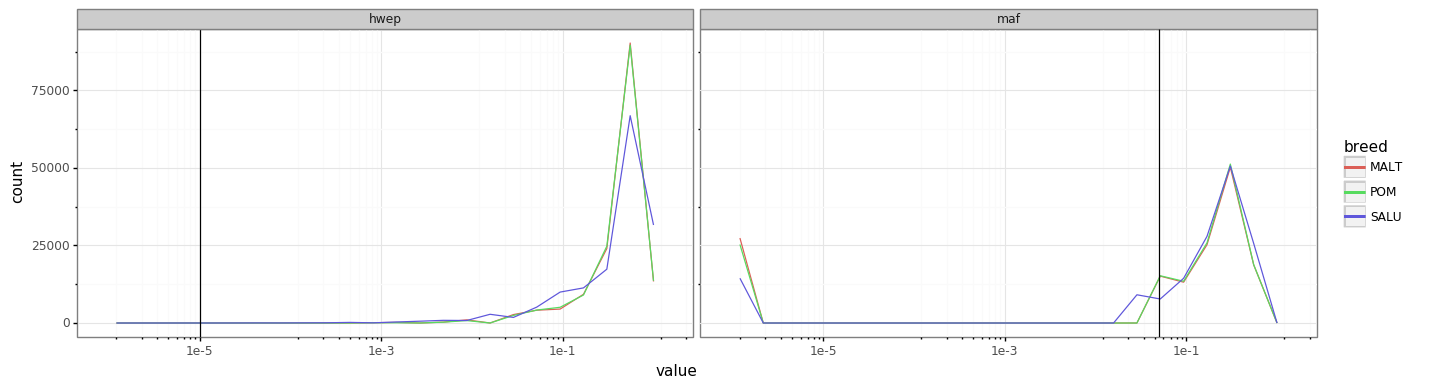

<ggplot: (8764419033465)>

In [141]:
(
    pn.ggplot(df_qc.assign(value=lambda df: df['value'] + 1e-6), pn.aes(x='value', color='breed')) + 
    pn.geom_freqpoly(bins=24) + 
    pn.geom_vline(data=df_qc[df_qc['metric'] == 'hwep'], mapping=pn.aes(xintercept=threshold_hwep)) + 
    pn.geom_vline(data=df_qc[df_qc['metric'] == 'maf'], mapping=pn.aes(xintercept=threshold_maf)) + 
    pn.scale_x_log10() + 
    pn.facet_wrap(' ~ metric') + 
    pn.theme_bw() + 
    pn.theme(figure_size=(16, 4))
)

In [150]:
def hwe_maf_qc(mt):
    cts = {}
    res = mt
    # TODO: Is there a more efficient way to do this?  It may make more sense 
    # to use boolean reduction on N mask arrays instead of successive joins
    for br in mts.keys():
        mtf = hl.variant_qc(mt.filter_cols(mt.breed == br))
        mtf = mtf.filter_rows((mtf.variant_qc.p_value_hwe > threshold_hwep) & (hl.min(mtf.variant_qc.AF) > threshold_maf))
        cts[br] = mtf.count()[0]
        res = res.semi_join_rows(mtf.rows())
    print('Number of variants after filtering by breed-specific QC thresholds: ', cts)
    return res

mt_qc = hwe_maf_qc(mt)
mt_qc.count()

Number of variants after filtering by breed-specific QC thresholds:  {'MALT': 107394, 'POM': 109464, 'SALU': 126316}


(84442, 1350)

In [151]:
mt_qc.write('/tmp/mt_ref_qc_2.mt', overwrite=True)

2020-02-11 06:51:59 Hail: INFO: wrote matrix table with 84442 rows and 1350 columns in 2 partitions to /tmp/mt_ref_qc_2.mt


#### LD Pruning

In [152]:
mt = hl.read_matrix_table('/tmp/mt_ref_qc_2.mt')
mt.count()

(84442, 1350)

In [155]:
ht_var = hl.ld_prune(mt.GT, r2=0.2, bp_window_size=1000000)
ht_var.describe()

2020-02-11 06:56:39 Hail: INFO: ld_prune: running local pruning stage with max queue size of 172961 variants
2020-02-11 06:56:43 Hail: INFO: wrote table with 44079 rows in 2 partitions to file:/tmp/hail.f5qEPdBMozAe/X5toNxBgBZ
2020-02-11 06:56:48 Hail: INFO: Wrote all 11 blocks of 44079 x 1350 matrix with block size 4096.
2020-02-11 06:57:28 Hail: INFO: wrote table with 0 rows in 21 partitions to file:/tmp/hail.f5qEPdBMozAe/MaMBefbJmi


----------------------------------------
Global fields:
    'variants_to_remove': set<int32> 
----------------------------------------
Row fields:
    'locus': locus<canine> 
    'alleles': array<str> 
----------------------------------------
Key: ['locus', 'alleles']
----------------------------------------


In [156]:
mt_pr = mt.filter_rows(hl.is_defined(ht_var[mt.row_key]))
mt_pr.count()

(44079, 1350)

In [157]:
mt_pr.write('/tmp/mt_ref_qc_3.mt', overwrite=True)

2020-02-11 06:58:32 Hail: INFO: wrote matrix table with 44079 rows and 1350 columns in 2 partitions to /tmp/mt_ref_qc_3.mt


#### Remove C/G and A/T SNPs

In [158]:
mt = hl.read_matrix_table('/tmp/mt_ref_qc_3.mt')
mt.count()

(44079, 1350)